In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/DS:Deep Learning in Python/NN -Fundamental concepts from scratch')

Reading in and transforming data
Cost at iteration i=0, j=0: 2067.201859
Error rate: 0.642
Cost at iteration i=0, j=10: 579.029239
Error rate: 0.161
Cost at iteration i=0, j=20: 366.788218
Error rate: 0.106
Cost at iteration i=0, j=30: 301.825985
Error rate: 0.087
Cost at iteration i=0, j=40: 262.871354
Error rate: 0.075
Cost at iteration i=0, j=50: 249.783437
Error rate: 0.078
Cost at iteration i=0, j=60: 229.381747
Error rate: 0.074
Cost at iteration i=0, j=70: 215.172322
Error rate: 0.059
Cost at iteration i=0, j=80: 200.103030
Error rate: 0.059
Cost at iteration i=1, j=0: 196.819883
Error rate: 0.059
Cost at iteration i=1, j=10: 186.500698
Error rate: 0.061
Cost at iteration i=1, j=20: 180.245172
Error rate: 0.056
Cost at iteration i=1, j=30: 171.741436
Error rate: 0.048
Cost at iteration i=1, j=40: 162.333952
Error rate: 0.043
Cost at iteration i=1, j=50: 163.646768
Error rate: 0.046
Cost at iteration i=1, j=60: 155.300501
Error rate: 0.037
Cost at iteration i=1, j=70: 151.714381


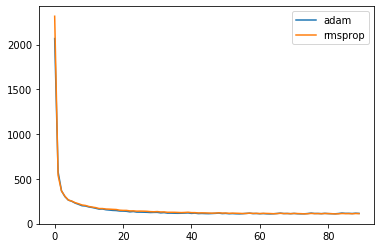

In [4]:
from __future__ import print_function, division
from builtins import range

import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from util import get_normalized_data, error_rate, cost, y2indicator
from mlp import forward, derivative_w2, derivative_w1, derivative_b2, derivative_b1


def main():
    max_iter = 10
    print_period = 10

    Xtrain, Xtest, Ytrain, Ytest = get_normalized_data()
    reg = 0.01

    Ytrain_ind = y2indicator(Ytrain)
    Ytest_ind = y2indicator(Ytest)

    N, D = Xtrain.shape
    batch_sz = 500
    n_batches = N // batch_sz

    M = 300
    K = 10
    W1_0 = np.random.randn(D, M) / np.sqrt(D)
    b1_0 = np.zeros(M)
    W2_0 = np.random.randn(M, K) / np.sqrt(M)
    b2_0 = np.zeros(K)

    W1 = W1_0.copy()
    b1 = b1_0.copy()
    W2 = W2_0.copy()
    b2 = b2_0.copy()

    # 1st moment
    mW1 = 0
    mb1 = 0
    mW2 = 0
    mb2 = 0

    # 2nd moment
    vW1 = 0
    vb1 = 0
    vW2 = 0
    vb2 = 0

    # hyperparams
    lr0 = 0.001
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8

    # 1. Adam
    loss_adam = []
    err_adam = []
    t = 1
    for i in range(max_iter):
        for j in range(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
            pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)

            # updates
            # gradients
            gW2 = derivative_w2(Z, Ybatch, pYbatch) + reg*W2
            gb2 = derivative_b2(Ybatch, pYbatch) + reg*b2
            gW1 = derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1
            gb1 = derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1

            # new m
            mW1 = beta1 * mW1 + (1 - beta1) * gW1
            mb1 = beta1 * mb1 + (1 - beta1) * gb1
            mW2 = beta1 * mW2 + (1 - beta1) * gW2
            mb2 = beta1 * mb2 + (1 - beta1) * gb2

            # new v
            vW1 = beta2 * vW1 + (1 - beta2) * gW1 * gW1
            vb1 = beta2 * vb1 + (1 - beta2) * gb1 * gb1
            vW2 = beta2 * vW2 + (1 - beta2) * gW2 * gW2
            vb2 = beta2 * vb2 + (1 - beta2) * gb2 * gb2

            # bias correction
            correction1 = 1 - beta1 ** t
            hat_mW1 = mW1 / correction1
            hat_mb1 = mb1 / correction1
            hat_mW2 = mW2 / correction1
            hat_mb2 = mb2 / correction1

            correction2 = 1 - beta2 ** t
            hat_vW1 = vW1 / correction2
            hat_vb1 = vb1 / correction2
            hat_vW2 = vW2 / correction2
            hat_vb2 = vb2 / correction2

            # update t
            t += 1

            # apply updates to the params
            W1 = W1 - lr0 * hat_mW1 / np.sqrt(hat_vW1 + eps)
            b1 = b1 - lr0 * hat_mb1 / np.sqrt(hat_vb1 + eps)
            W2 = W2 - lr0 * hat_mW2 / np.sqrt(hat_vW2 + eps)
            b2 = b2 - lr0 * hat_mb2 / np.sqrt(hat_vb2 + eps)


            if j % print_period == 0:
                pY, _ = forward(Xtest, W1, b1, W2, b2)
                l = cost(pY, Ytest_ind)
                loss_adam.append(l)
                print("Cost at iteration i=%d, j=%d: %.6f" % (i, j, l))

                err = error_rate(pY, Ytest)
                err_adam.append(err)
                print("Error rate:", err)

    pY, _ = forward(Xtest, W1, b1, W2, b2)
    print("Final error rate:", error_rate(pY, Ytest))


    # 2. RMSprop with momentum
    W1 = W1_0.copy()
    b1 = b1_0.copy()
    W2 = W2_0.copy()
    b2 = b2_0.copy()
    loss_rms = []
    err_rms = []

    # comparable hyperparameters for fair comparison
    lr0 = 0.001
    mu = 0.9
    decay_rate = 0.999
    eps = 1e-8

    # rmsprop cache
    cache_W2 = 1
    cache_b2 = 1
    cache_W1 = 1
    cache_b1 = 1

    # momentum
    dW1 = 0
    db1 = 0
    dW2 = 0
    db2 = 0
    
    for i in range(max_iter):
        for j in range(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
            pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)

            # updates
            gW2 = derivative_w2(Z, Ybatch, pYbatch) + reg*W2
            cache_W2 = decay_rate*cache_W2 + (1 - decay_rate)*gW2*gW2
            dW2 = mu * dW2 + (1 - mu) * lr0 * gW2 / (np.sqrt(cache_W2) + eps)
            W2 -= dW2

            gb2 = derivative_b2(Ybatch, pYbatch) + reg*b2
            cache_b2 = decay_rate*cache_b2 + (1 - decay_rate)*gb2*gb2
            db2 = mu * db2 + (1 - mu) * lr0 * gb2 / (np.sqrt(cache_b2) + eps)
            b2 -= db2

            gW1 = derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1
            cache_W1 = decay_rate*cache_W1 + (1 - decay_rate)*gW1*gW1
            dW1 = mu * dW1 + (1 - mu) * lr0 * gW1 / (np.sqrt(cache_W1) + eps)
            W1 -= dW1

            gb1 = derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1
            cache_b1 = decay_rate*cache_b1 + (1 - decay_rate)*gb1*gb1
            db1 = mu * db1 + (1 - mu) * lr0 * gb1 / (np.sqrt(cache_b1) + eps)
            b1 -= db1

            if j % print_period == 0:
                pY, _ = forward(Xtest, W1, b1, W2, b2)
                l = cost(pY, Ytest_ind)
                loss_rms.append(l)
                print("Cost at iteration i=%d, j=%d: %.6f" % (i, j, l))

                err = error_rate(pY, Ytest)
                err_rms.append(err)
                print("Error rate:", err)

    pY, _ = forward(Xtest, W1, b1, W2, b2)
    print("Final error rate:", error_rate(pY, Ytest))

    plt.plot(loss_adam, label='adam')
    plt.plot(loss_rms, label='rmsprop')
    plt.legend()
    plt.show()


if __name__ == '__main__':
    main()